In [19]:
import rpy2.robjects as robjects
from rpy2.robjects import r, pandas2ri
import numpy as np
from pyabc import Distribution, RV, ABCSMC
from pyabc.sampler import SingleCoreSampler
from pyabc.transition import MultivariateNormalTransition
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from IPython.display import TextDisplayObject

In [24]:
from pygments import highlight
from pygments.lexers import SLexer

from pygments.formatters import HtmlFormatter
import IPython

with open('pyABC_blueprint.R') as f:
    code = f.read()

formatter = HtmlFormatter()
IPython.display.HTML('<style type="text/css">{}</style>{}'.format(
    formatter.get_style_defs('.highlight'),
    highlight(code, SLexer(), formatter)))

In [2]:
blue_print = robjects.r["source"]("pyABC_blueprint.R")

In [3]:
model = robjects.r["model"]
distance = robjects.r["distance"]
summary_statistics = robjects.r["summaryStatistics"]
summary_statistics.__name__ = "summaryStatistics"

In [4]:
def convert_numeric(x):
    arr = np.array(x)
    try:
        return float(arr)
    except TypeError:
        return arr
    

def named_list_to_dict(r_named_list):
    return {key: convert_numeric(val) for key, val in zip(r_named_list.names, r_named_list)}

In [5]:
def model_py(par):
    return model(robjects.r.list(**par))

def distance_py(*args):
    return float(np.array(distance(*args)))

In [6]:
prior = Distribution(x=RV("uniform", 0, 10),
                     y=RV("uniform", 0, 10))
abc = ABCSMC(model_py, prior, distance_py, sampler=SingleCoreSampler(),
             summary_statistics=summary_statistics)

In [7]:
abc.new("sqlite:////home/emmanuel/tmp/abctest.db",
        robjects.r["observation"])

INFO:Epsilon:initial epsilon is 7.127650626080321
INFO:History:Start <ABCSMC(id=14, start_time=2017-07-25 17:18:48.714937, end_time=None)>


14

In [8]:
abc.run(minimum_epsilon=0, max_nr_populations=7)

INFO:ABC:t:0 eps:7.12765062608
INFO:ABC:t:1 eps:4.350452323590881
INFO:ABC:t:2 eps:3.053934381790566
INFO:ABC:t:3 eps:2.233466185827349
INFO:ABC:t:4 eps:1.623580931111455
INFO:ABC:t:5 eps:1.2100306526374365
INFO:ABC:t:6 eps:0.8569187811398395
INFO:History:Done <ABCSMC(id=14, start_time=2017-07-25 17:18:48.714937, end_time=2017-07-25 17:18:59.359504)>


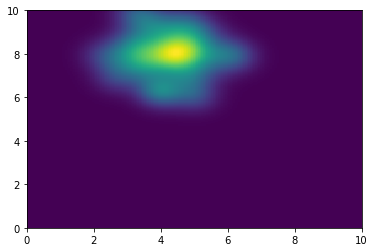

In [18]:
df, w = abc.history.get_distribution(0)
kde = MultivariateNormalTransition(scaling=1)
kde.fit(df,w)
n_points = 200
X, Y = np.meshgrid(np.linspace(0,10, n_points), np.linspace(0, 10, n_points))
test = pd.DataFrame({"x": X.flatten(), "y": Y.flatten()})
pdf = kde.pdf(test)
PDF = pdf.reshape(X.shape)
plt.pcolormesh(X, Y, PDF);